In [195]:
import numpy as np

experiment_configs = [{"device_name": ["GeForce GTX TITAN Black"],
                       "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d"],
                       "n_neurons_l0": np.arange(32, 1024, 32),
                       "n_inputs": np.arange(32, 1024, 32),
                       "mults_per_thread": [1],
                       "neurons_per_wrg": [1]}]

def get(key, arr):
    return np.asarray([dict_el[key] for dict_el in arr])

In [464]:
import os
import pprint
import pandas as pd

def load_experiments():
    #experiment_dir = "experiment." + network_config
    results_lift = None
    i = 0
    for experiment_dir in filter(
        lambda x: os.path.isdir(os.path.join(".", x)) and 
        x.startswith("experiment.") and 
        os.path.isdir(os.path.join(".", x, "results_lift")), 
        os.listdir(".")):
        results_lift_dir = os.path.join(".", experiment_dir, "results_lift")

        for filename in os.listdir(results_lift_dir):
            single_csv = pd.read_csv(os.path.join(results_lift_dir, filename), index_col=False)
            single_csv["datetime"] = filename[:filename.find("_")]
            single_csv["n_neurons_l0"] = int(experiment_dir[15:experiment_dir.find("-", 15)])
            if results_lift is not None:
                results_lift = results_lift.append(single_csv, ignore_index=True)                
            else:
                results_lift = single_csv
            i = i + 1
            if i % 20 == 0:
                print(".", end="")
    print()
    return results_lift

def matches(result, config):
    for (key, allowed_values) in config.items():
        if key in result and (
            (isinstance(result[key], float) and result[key] in allowed_values) or
            (isinstance(result[key], str) and result[key] in 
                 [value.replace("\x00","") for value in allowed_values])):
            next
        else:
            return False
    return True

def filter_experiments(experiment_configs, nonfiltered_results):
    results = []
    for config in experiment_configs:
        results.append(nonfiltered_results[np.all([
                        nonfiltered_results[k].isin(vs) for k, vs in config.items()], axis=0)])
        #results.append([result for result in nonfiltered_results if matches(result, config)])
    return results

nonfiltered_results = load_experiments()

results = filter_experiments(experiment_configs, nonfiltered_results)
data_is_reset = True
print("%d non-filtered results." % len(nonfiltered_results))
#pp.pprint(nonfiltered_results)
print("%d filtered results for experiment 0:" % len(results[0]))
print(results[0][0:2])

print("Loaded " + str(len(results)) + " experiment(s):")
for exp_i in range(len(results)):
    print("Experiment " + str(exp_i) + ": " + str(len(results[exp_i])) + " records")
    
# results_folded = []
# for exp_i in range(len(results)):
#     ipn = results[exp_i].loc[[0]]["n_inputs"] / results[exp_i].loc[[0]]["layer_len1"]
#     ipnps_l0 = ipn / results["runtime_l0"]
#     ipnps_l1 = ipn / get("runtime_l1", results[exp_i])
#     ipnps_l2 = ipn / get("runtime_l2", results[exp_i])
#     results_folded.append(
#         {"ipnps_mean_l0": np.mean(ipnps_l0),
#          "ipnps_std_l0": np.std(ipnps_l0),
#          "ipnps_mean_l1": np.mean(ipnps_l1),
#          "ipnps_std_l1": np.std(ipnps_l1)})

# pp.pprint(results_folded)

..........................................................................................
1812 non-filtered results.
414 filtered results for experiment 0:
               device_name                                  f_name  n_inputs  \
2  GeForce GTX TITAN Black  f_layer_complex_neuron_mrgd_wrgs_in_2d        32   
6  GeForce GTX TITAN Black  f_layer_complex_neuron_mrgd_wrgs_in_2d        64   

   mults_per_thread  neurons_per_wrg  layer_len0  layer_len1  layer_len2  \
2                 1                1          32          32          10   
6                 1                1          32          32          10   

  activation_f0 activation_f1 activation_f2  runtime_l0  runtime_l1  \
2          ReLU          ReLU            id     0.36019     0.01126   
6          ReLU          ReLU            id     0.71053     0.01366   

   runtime_l2                 datetime  n_neurons_l0  
2     0.01370  14.07.2016-04.47.47.932            32  
6     0.00813  14.07.2016-04.47.51.556           

In [466]:
# Format data
if data_is_reset:
    # Runtimes: s -> ms
    original_status = pd.options.mode.chained_assignment
    pd.options.mode.chained_assignment = None
    for result in results:
        result.loc[:, "runtime_l0"] = result["runtime_l0"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l1"] = result["runtime_l1"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l2"] = result["runtime_l2"].apply(lambda x: x * 1000)
    pd.options.mode.chained_assignment = original_status
    print ("Data was formatted.")
    data_is_reset = False

In [470]:
def ipnps(df):
    if df.empty:
        return 0
    else:
        return df["n_inputs"] / (df["layer_len1"] * df["runtime_l0"])

In [471]:
# Prepares data
experiment = results[0]

n_n_neurons = int(1024 / 32 - 1)
n_n_inputs = int(1888 / 32 - 1)
matrix = np.zeros((n_n_neurons, n_n_inputs), dtype=np.float32)
for n_neurons in np.arange(n_n_neurons):
    for n_inputs in np.arange(n_n_inputs):
        matrix[n_neurons, n_inputs] = np.nan_to_num(
            experiment[(experiment["layer_len0"] == 32 + n_neurons * 32) &
                       (experiment["n_inputs"] == 32 + n_inputs * 32)]\
            [["n_inputs", "layer_len1", "runtime_l0"]]\
            .apply(ipnps, axis=1).mean())
        print(".", end="")
print()
matrix2 = np.zeros((matrix.shape[0] + 1, matrix.shape[1] + 1))
matrix2[1:, 1:] = matrix[:, :]
matrix = matrix2.transpose()
print("Matrix shape:", matrix.shape)
print("Data prepared.")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

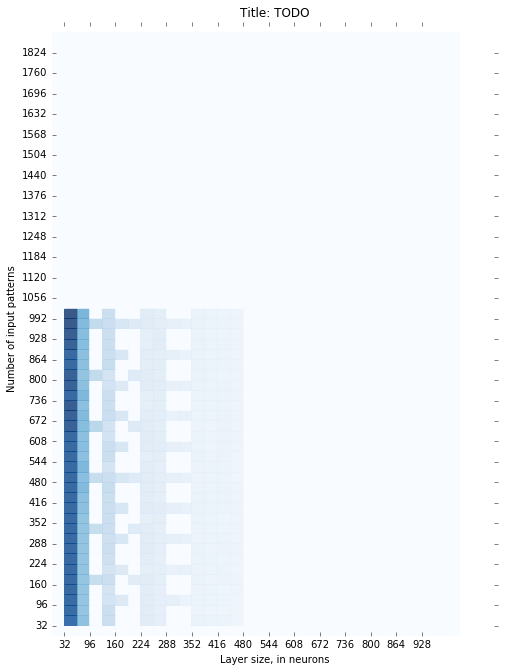

In [472]:
# Renders the plot
fig, ax = plt.subplots()
heatmap = ax.pcolor(matrix, cmap=plt.cm.Blues, alpha=0.8)
ax.set_title('Title: TODO')
ax.set_xlabel('Layer size, in neurons')
ax.set_ylabel('Number of input patterns')
ax.set_xticks(np.arange(1, n_n_neurons, 2))
ax.set_xticklabels(np.arange(32, 1024, 32 * 2))
ax.set_yticks(np.arange(1, n_n_inputs, 2))
ax.set_yticklabels(np.arange(32, 1888, 32 * 2))

# Format
fig = plt.gcf()
fig.set_size_inches(8, 11)
# turn off the frame
ax.set_frame_on(False)
# print(experiment.as_matrix(columns=["n_inputs"]))
# print(experiment.as_matrix(columns=["runtime_l0"]))